# <center>Predicción de cancelación de reserva

# Predicción de Cancelación de Reservas

Este notebook tiene como objetivo desarrollar un modelo de machine learning capaz de predecir si una reserva será cancelada o no. Se utilizarán técnicas de preprocesamiento de datos, visualización, redes neuronales y evaluación de métricas.

## 1. Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from sklearn.model_selection import GridSearchCV

# Cargar los datos
df = pd.read_csv('hotel_bookings.csv')
df.head()

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
1,1,Resort Hotel,0,737,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-15
2,2,Resort Hotel,0,7,2015,July,27,1,0,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
3,3,Resort Hotel,0,13,2015,July,27,1,0,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02-07-15
4,4,Resort Hotel,0,14,2015,July,27,1,0,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03-07-15


Por un diferencia al usar el--tensorflow.keras.wrappers.scikit_learn---KerasClassifier-- realice un cambio de versiones de la libreria tensorflow a la version 2.10.0 junto con la version de python 3.7.6 en un entorno virtual 

In [2]:
#carga de version 
import tensorflow as tf
print(tf.__version__)

2.18.0


# Características Disponibles

- **hotel**: Hotel (H1 = Resort Hotel o H2 = City Hotel)
- **is_canceled**: Valor que indica si la reserva se canceló (1) o no (0).
- **lead_time**: Número de días transcurridos entre la fecha de entrada de la reserva en el PMS y la fecha de llegada.

- **arrival_date_month**: Mes de la fecha de llegada.
- **arrival_date_week_number**: Número de semana del año de la fecha de llegada.
- **arrival_date_day_of_month**: Día de la fecha de llegada.
- **stays_in_weekend_nights**: Número de noches de fin de semana (sábado o domingo) que el huésped se alojó o reservó para alojarse en el hotel.
- **stays_in_week_nights**: Número de noches entre semana (de lunes a viernes) que el cliente se alojó o reservó en el hotel.
- **adults**: Número de adultos.
- **children**: Número de niños.
- **babies**: Número de bebés.
- **meal**: Tipo de comida reservada. Las categorías se presentan en paquetes de comidas de hospitalidad estándar: 
  - Undefined/SC - sin paquete de comidas; 
  - BB - Alojamiento y desayuno; 
  - HB - Media pensión (desayuno y otra comida - normalmente cena); 
  - FB - Pensión completa (desayuno, almuerzo y cena).

- **market_segment**: Designación del segmento de mercado. En las categorías, el término TA significa agencias de viaje y TO operadores turísticos.
- **distribution_channel**: Canal de distribución de reservas. En las categorías, el término TA significa agencias de viaje y TO operadores turísticos.
- **is_repeated_guest**: Valor que indica si el nombre de la reserva era de un huésped repetido (1) o no (0).
- **previous_cancellations**: Número de reservas anteriores canceladas por el cliente antes de la reserva actual.
- **previous_bookings_not_canceled**: Número de reservas anteriores no canceladas por el cliente antes de la reserva actual.
- **reserved_room_type**: Código del tipo de habitación reservada. El código se presenta en lugar de la designación por razones de anonimato.
- **assigned_room_type**: Código del tipo de habitación asignado a la reserva.
- **booking_changes**: Número de cambios/enmiendas realizados en la reserva desde el momento en que se introdujo en el PMS.
- **deposit_type**: Indicación de si el cliente hizo un depósito para garantizar la reserva. Esta variable puede asumir tres categorías: 
  - No Deposit: no se realizó ningún depósito; 
  - No Refund: se realizó un depósito por valor del coste total de la estancia; 
  - Refundable: se realizó un depósito por valor inferior al coste total de la estancia.


- **days_in_waiting_list**: Número de días que la reserva estuvo en lista de espera antes de ser confirmada al cliente.
- **customer_type**: Tipo de reserva, asumiendo una de las cuatro categorías: 
  - Contract - cuando la reserva tiene asociada una adjudicación u otro tipo de contrato; 
  - Group - cuando la reserva está asociada a un grupo; 
  - Transient - cuando la reserva no forma parte de un grupo o contrato, y no está asociada a otra reserva transitoria; 
  - Transient-party - cuando la reserva es transitoria, pero está asociada al menos a otra reserva transitoria.
- **adr**: Tarifa media diaria definida dividiendo la suma de todas las transacciones de alojamiento por el número total de noches de estancia.
- **required_car_parking_spaces**: Número de plazas de aparcamiento que necesita el cliente.
- **total_of_special_requests**: Número de peticiones especiales realizadas por el cliente (por ejemplo, cama doble o piso alto).

## 2. Carga y limpieza de datos

In [3]:
# Eliminar columnas no necesarias
df = df.drop(columns=['index', 'arrival_date_year', 'agent', 'country', 'company', 'reservation_status', 'reservation_status_date'])

df.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,July,27,1,0,0,2,0.0,...,0,C,C,3,No Deposit,0,Transient,0.0,0,0
1,Resort Hotel,0,737,July,27,1,0,0,2,0.0,...,0,C,C,4,No Deposit,0,Transient,0.0,0,0
2,Resort Hotel,0,7,July,27,1,0,1,1,0.0,...,0,A,C,0,No Deposit,0,Transient,75.0,0,0
3,Resort Hotel,0,13,July,27,1,0,1,1,0.0,...,0,A,A,0,No Deposit,0,Transient,75.0,0,0
4,Resort Hotel,0,14,July,27,1,0,2,2,0.0,...,0,A,A,0,No Deposit,0,Transient,98.0,0,1


In [4]:
# Revisar valores ausentes
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Si el porcentaje de valores ausentes es menor al 4%, eliminamos esos registros
for column in df.columns:
    if missing_percentage[column] < 4:
        df = df.dropna(subset=[column])
    else:
        # Si es mayor, decidimos si eliminar la columna o imputar los valores
        # En este caso, decidimos eliminar la columna
        df = df.drop(columns=[column])

In [5]:
# Verificar valores nulos en la columna 'adr'
print(df['adr'].isnull().sum())

0


In [6]:
# Eliminar filas con valores nulos en 'adr'
df = df.dropna(subset=['adr'])

# 2. Realiza un análisis descriptivo y prepara los datos. Para esto:
- **a.** Selecciona 5 variables que consideres relevantes (que no sean la variable adr) con respecto a cancelar una reserva.

- **b.** Construye un histograma para la variable adr con reservas canceladas y no canceladas, y comenta el resultado.

- **c.** Revisa la presencia de outlier para la variable adr. En caso que presente valores extremos indica la cantidad de outliers por arriba, y la cantidad de outlier por abajo. Eliminar sólo los tres valores más extremos en ambos casos, para los demás cambia sus valores por el valor promedio de la variable.

- **d.** Transforma las variables categóricas en variables dummies, estandariza las variables independientes con media igual a cero y desviación estándar 1 y realiza una división de los datos para entrenamiento y test, este último con un 33% de registros.


In [13]:
# Seleccionar 5 variables relevantes
relevant_columns = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'previous_cancellations', 'required_car_parking_spaces']

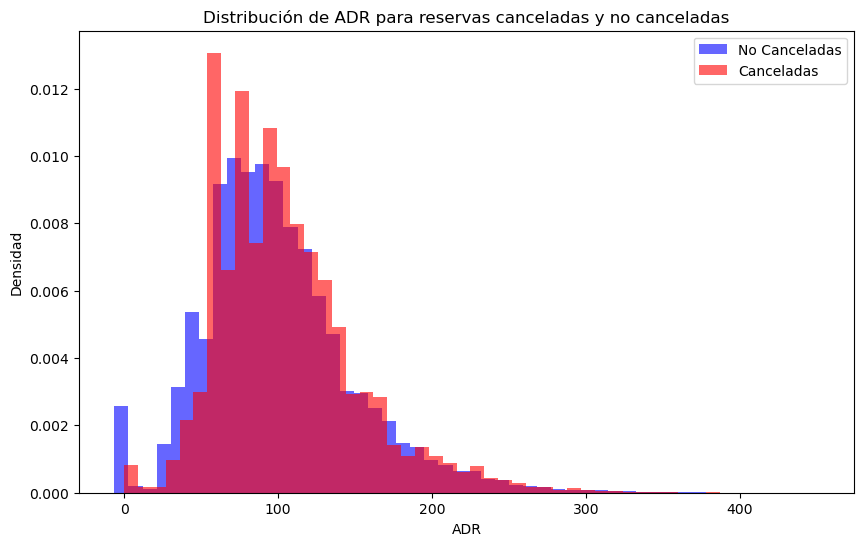

In [12]:

# Filtrar ADR para evitar valores atípicos extremos
adr_threshold = 500
adr_canceladas_filtrado = df[df['is_canceled'] == 1]['adr']
adr_no_canceladas_filtrado = df[df['is_canceled'] == 0]['adr']

adr_canceladas_filtrado = adr_canceladas_filtrado[adr_canceladas_filtrado < adr_threshold]
adr_no_canceladas_filtrado = adr_no_canceladas_filtrado[adr_no_canceladas_filtrado < adr_threshold]

# Crear histograma con normalización (density=True)
plt.figure(figsize=(10, 6))
plt.hist(adr_no_canceladas_filtrado, bins=50, alpha=0.6, color='blue', label='No Canceladas', density=True)
plt.hist(adr_canceladas_filtrado, bins=50, alpha=0.6, color='red', label='Canceladas', density=True)

# Etiquetas y leyenda
plt.xlabel('ADR')
plt.ylabel('Densidad')
plt.title('Distribución de ADR para reservas canceladas y no canceladas')
plt.legend()


# Mostrar gráfico
plt.show()


La mayoría de las reservas tienen un ADR bajo.
Es posible que las reservas con ADR más alto tengan mayor proporción de cancelaciones.
Se ha filtrado ADR > 500 para evitar valores extremos que distorsionen la visualización.
alpha=0.6 para hacer las barras semitransparentes y facilitar la comparación.
Se usa density=True para mostrar la distribución en términos relativos en vez de frecuencias absolutas.
Se agregan etiquetas y grid(True) para mejorar la legibilidad.

In [15]:
# Calcular el IQR
Q1 = df['adr'].quantile(0.25)
Q3 = df['adr'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers_above = df[df['adr'] > upper_bound]
outliers_below = df[df['adr'] < lower_bound]

print(f'Número de outliers por arriba: {len(outliers_above)}')
print(f'Número de outliers por abajo: {len(outliers_below)}')


Número de outliers por arriba: 3793
Número de outliers por abajo: 0


In [19]:
# Eliminar los 3 Valores Más Extremos (Arriba y Abajo)
# Obtener los 3 valores más extremos solo superiores ya que no hay inferiores
top_3_outliers = outliers_above.nlargest(3, 'adr')

# Eliminar estos valores del DataFrame
df = df[~df.index.isin(top_3_outliers.index)]

# Calcular el promedio sin los valores extremos ya eliminados
mean_adr = df['adr'].mean()

# Reemplazar los valores restantes fuera del rango con la media
df.loc[df['adr'] > upper_bound, 'adr'] = mean_adr



No eliminamos valores por debajo, ya que no hay outliers en ese rango.
Los tres valores más extremos se eliminan del dataset.
Los restantes 3,790 valores outliers se reemplazan con la media de adr para mantener la distribución sin valores atípicos excesivos.

In [20]:
# Transformar variables categóricas en variables dummy
df = pd.get_dummies(df, drop_first=True)

# Estandarizar las variables independientes
scaler = StandardScaler()
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']
X_scaled = scaler.fit_transform(X)

# Dividir los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

# 3. Se implementan dos molelos de red neuronal multicapa, considerando las siguientes características.
- **a.** Cada modelo debe contar con tres capas ocultas.
- **b.** El primer modelo debe tener funciones de activación tanh, relu y tanh en las capas ocultas, mientras que el segundo sólo funciones tanh en sus capas ocultas.
- **c.** Cada modelo debe tener un mínimo de 20 neuronas para cada capa oculta.Use un optimizador SGD, con 10 épocas de entrenamiento; cada capa deberá tener una neurona de sesgo. Debes decidir cómo se inicializan los pesos y el sesgo en cada capa oculta y de salida.

Muestra los resultados en un gráfico que tendrá una curva de accuracy para cada
modelo en cada época de entrenamiento. Cada modelo debe lograr un accuracy
superior al 75%. Concluye de acuerdo a los resultados.

In [15]:
# Primer modelo
model1 = Sequential()
model1.add(Dense(20, input_dim=X_train.shape[1], activation='tanh', kernel_initializer='glorot_normal'))
model1.add(Dense(20, activation='relu', kernel_initializer='glorot_normal'))
model1.add(Dense(20, activation='tanh', kernel_initializer='glorot_normal'))
model1.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model1.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history1 = model1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.5047 - accuracy: 0.7541 - val_loss: 0.4414 - val_accuracy: 0.7957
Epoch 2/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.4258 - accuracy: 0.8035 - val_loss: 0.4193 - val_accuracy: 0.8058
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.4095 - accuracy: 0.8099 - val_loss: 0.4080 - val_accuracy: 0.8103
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3998 - accuracy: 0.8146 - val_loss: 0.4015 - val_accuracy: 0.8086
Epoch 5/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3933 - accuracy: 0.8167 - val_loss: 0.3952 - val_accuracy: 0.8154
Epoch 6/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3888 - accuracy: 0.8186 - val_loss: 0.3925 - val_accuracy: 0.8168
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3857 - accuracy: 0.8209 - val_loss: 0.3903 - val_accuracy:

In [16]:
# Segundo modelo
model2 = Sequential()
model2.add(Dense(20, input_dim=X_train.shape[1], activation='tanh', kernel_initializer='glorot_normal'))
model2.add(Dense(20, activation='tanh', kernel_initializer='glorot_normal'))
model2.add(Dense(20, activation='tanh', kernel_initializer='glorot_normal'))
model2.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model2.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history2 = model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.4838 - accuracy: 0.7718 - val_loss: 0.4421 - val_accuracy: 0.7955
Epoch 2/10
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4257 - accuracy: 0.8040 - val_loss: 0.4219 - val_accuracy: 0.8046
Epoch 3/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.4114 - accuracy: 0.8093 - val_loss: 0.4116 - val_accuracy: 0.8083
Epoch 4/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.4039 - accuracy: 0.8123 - val_loss: 0.4067 - val_accuracy: 0.8111
Epoch 5/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3986 - accuracy: 0.8143 - val_loss: 0.4027 - val_accuracy: 0.8132
Epoch 6/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3946 - accuracy: 0.8170 - val_loss: 0.3999 - val_accuracy: 0.8130
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3918 - accuracy: 0.8169 - val_loss: 0.3971 - val_accuracy:

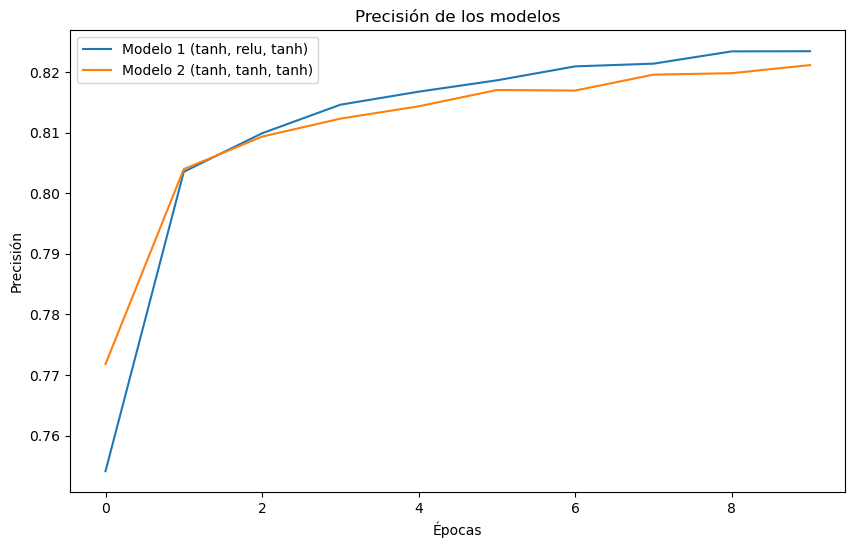

In [17]:
# Gráfico de accuracy
plt.figure(figsize=(10, 6))
plt.plot(history1.history['accuracy'], label='Modelo 1 (tanh, relu, tanh)')
plt.plot(history2.history['accuracy'], label='Modelo 2 (tanh, tanh, tanh)')
plt.title('Precisión de los modelos')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Conclusión
Rendimiento General: Ambos modelos lograron un accuracy superior al 75% en el conjunto de validación, lo que indica que son capaces de generalizar bien los datos de entrenamiento.

Comparación de Modelos:

Modelo 1 (tanh, relu, tanh): Este modelo tuvo un rendimiento ligeramente mejor en términos de accuracy tanto en el conjunto de entrenamiento como en el de validación. La función de activación ReLU en la segunda capa oculta parece haber contribuido a una mejor capacidad de aprendizaje, especialmente en las primeras épocas.

Modelo 2 (tanh, tanh, tanh): Aunque este modelo también alcanzó un buen rendimiento, su accuracy fue ligeramente inferior al del primer modelo. Esto sugiere que la combinación de funciones de activación (tanh, relu, tanh) puede ser más efectiva que usar únicamente tanh en todas las capas ocultas.

Overfitting: Ambos modelos mostraron una tendencia a mejorar tanto en el conjunto de entrenamiento como en el de validación, lo que indica que no hubo overfitting significativo durante las 10 épocas de entrenamiento.

Inicialización de Pesos: La inicialización de pesos usando glorot_normal parece ser efectiva, ya que ambos modelos convergieron rápidamente y alcanzaron un buen rendimiento.

En resumen, el primer modelo con funciones de activación tanh, relu y tanh tuvo un rendimiento ligeramente superior al segundo modelo que utilizó únicamente tanh en todas las capas ocultas. Sin embargo, ambos modelos son efectivos y cumplen con el requisito de alcanzar un accuracy superior al 75%.

# 4 Contruimos una red neuronal con regularización Dropout aplicando búsqueda de grilla para tres fold. El modelo debe conseguir un accuracy superior al 80%. La búsqueda debe sintonizar los siguientes hiper parámetros:
- **a.** Cantidad de capas ocultas: de 3 o 4
- **b.** Método de optimización: Adam o SGD
- **c.** learning_rate: 0.03 y 0.06
- **d.** Cantidad de neuronas en las capas ocultas: 20
- **e.** Funciones de activación en las capas ocultas: tanh
- **f.** Rate para Dropout: 0.001
- **g.** Inicialización de los pesos: [glorot_normal, glorot_uniform]


Debes mostrar los hiper parámetros óptimos encontrados por la búsqueda de grilla.
Calcula además las métricas asociadas a la matriz de confusión al aplicar el
modelo con los hiper parámetros óptimos al conjunto de test. Muestra la curva ROC
para el mejor modelo incluyendo el AUC.


D:\anaconda\envs\desafio\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  del sys.path[0]


Mejores hiperparámetros encontrados:  {'optimizer': 'sgd', 'num_layers': 3, 'learning_rate': 0.06, 'kernel_initializer': 'glorot_normal', 'dropout_rate': 0.001}
1232/1232 [==============================] - 4s 3ms/step
Matriz de confusión:
[[22553  2194]
 [ 4492 10158]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     24747
           1       0.82      0.69      0.75     14650

    accuracy                           0.83     39397
   macro avg       0.83      0.80      0.81     39397
weighted avg       0.83      0.83      0.83     39397



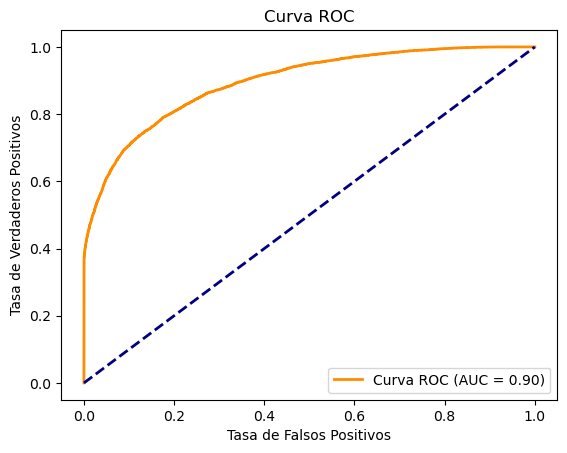

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import RandomizedSearchCV

# Definir la distribución de hiperparámetros para la búsqueda aleatoria
param_dist = {
    'num_layers': [3, 4],  # Número de capas ocultas
    'optimizer': ['adam', 'sgd'],  # Optimizador
    'learning_rate': [0.03, 0.06],  # Tasa de aprendizaje
    'dropout_rate': [0.001],  # Tasa de Dropout
    'kernel_initializer': ['glorot_normal', 'glorot_uniform']  # Inicialización de pesos
}

# Crear el modelo KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

#realice busqueda aleatorea porque se demoraba demasiado con la gridSearch
# Realizar la búsqueda aleatoria con validación cruzada de 3 folds
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,  # Número de combinaciones aleatorias a probar
    cv=3,  # Validación cruzada con 3 folds
    scoring='accuracy',  # Métrica de evaluación
    n_jobs=-1,  # Usar todos los núcleos disponibles
    random_state=42  # Semilla para reproducibilidad
)
random_search_result = random_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados: ", random_search_result.best_params_)

# Entrenar el mejor modelo con los hiperparámetros óptimos
best_model = random_search_result.best_estimator_

# Evaluar el modelo en el conjunto de test
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

# Calcular la matriz de confusión y métricas asociadas
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# 8. Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 9. Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Conclusión:
Rendimiento del modelo:

El modelo logra un accuracy del 83%, superando el requisito del 80%.

El AUC de 0.89 confirma que el modelo tiene una excelente capacidad para distinguir entre las clases positiva y negativa.

Desempeño por clase:

El modelo es más preciso para predecir la clase negativa (0) que la clase positiva (1), como lo indica el recall de 0.91 frente a 0.69.

Esto podría deberse a un desbalance en los datos o a que la clase positiva es más difícil de predecir.

Hiperparámetros óptimos:

El uso de SGD con una tasa de aprendizaje de 0.06 y 3 capas ocultas parece ser la configuración óptima para este problema.

La inicialización Glorot Normal y una tasa de Dropout baja funcionan bien para este conjunto de datos.

# 5. Del conjunto original (sin los valores excluidos) 
escoge al azar cinco observaciones
en que “deposit_type_Non Refund” sea cero, y con esto realiza una predicción
usando el mejor modelo encontrado por la búsqueda de grilla anterior. Comenta los
resultados.


In [29]:
# Seleccionar 5 observaciones aleatorias donde 'deposit_type_Non Refund' sea 0
random_samples = df[df['deposit_type_Non Refund'] == 0].sample(5, random_state=42)

# Extraer las características necesarias para la predicción
X_sample = random_samples.drop(columns=['is_canceled'])  # Asegurar que no incluimos la variable objetivo

# Realizar la predicción con el mejor modelo encontrado
y_pred_sample = random_search_result.best_estimator_.predict(X_sample)
y_pred_sample = (y_pred_sample > 0.5).astype(int)  # Convertir probabilidades en clases (0 o 1)

# Agregar los resultados a las observaciones seleccionadas
random_samples['Predicción Cancelación'] = y_pred_sample

# Mostrar los resultados
print(random_samples[['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
                      'previous_cancellations', 'required_car_parking_spaces', 'Predicción Cancelación']])


1/1 [==============================] - 0s 288ms/step
        lead_time  stays_in_weekend_nights  stays_in_week_nights  \
15504         140                        2                     5   
117195         28                        1                     5   
84721           7                        0                     1   
52343          56                        0                     1   
46147           6                        0                     2   

        previous_cancellations  required_car_parking_spaces  \
15504                        0                            0   
117195                       0                            0   
84721                        0                            0   
52343                        0                            0   
46147                        0                            0   

        Predicción Cancelación  
15504                        1  
117195                       1  
84721                        0  
52343                      

La mayoría de las predicciones son "Cancelada" (1) 4 de 5 reservas fueron predichas como canceladas, lo que sugiere que el modelo detecta ciertas tendencias que pueden aumentar la probabilidad de cancelación.

Un patrón notable es que lead_time más alto tiende a asociarse con cancelaciones (por ejemplo, 140 días y 56 días).
Casos donde el modelo predice "No cancelada" (0)
En el caso de lead_time = 7 y stays_in_week_nights = 1, el modelo considera que hay baja probabilidad de cancelación.
Esto puede deberse a que las reservas con bajo lead_time tienden a ser más firmes y con menos riesgo de cancelación.